# Movielens 영화 SBR

Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 만들어보자.

## 0. 모듈 import

In [1]:
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from pathlib import Path

import os
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## 1. 데이터 확인하기

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

총 데이터는 100만개 가량에,  
대략 6000개의 유저아이디와 3700개의 영화 정보가 있다.

In [4]:
data.describe()

,UserId,ItemId,Rating,Time
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


영화 평점(rating)은 최소 1점에서 최대 5점이다.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


모두 int형으로 따로 결측치는 없다.

In [6]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


시간은 UTC time 으로 1970년 1월 1일부터 경과된 초단위 시간으로 되어있다.

다음은 데이터 셋에 대한 요약이다.

In [7]:
read_path = data_path / 'README'
f = open(read_path)
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

SUMMARY




These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 

made by 6,040 MovieLens users who joined MovieLens in 2000.



USAGE LICENSE




Neither the University of Minnesota nor any of the researchers

involved can guarantee the correctness of the data, its suitability

for any particular purpose, or the validity of results based on the

use of the data set.  The data set may be used for any research

purposes under the following conditions:



     * The user may not state or imply any endorsement from the

       University of Minnesota or the GroupLens Research Group.



     * The user must acknowledge the use of the data set in

       publications resulting from the use of the data set

       (see below for citation information).



     * The user may not redistribute the data without separate

       permission.



     * The user may not use this information for any commercial or

       revenue-bearing purposes without first obtaining permi

## 2. 데이터의 전처리

평가 점수가 3점 이상인 데이터만 사용한다.
추천 시스템이기 때문에 2점 이하의 평가는 추천에서 제외한다.

In [8]:
data = data[data['Rating'] >= 3]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


userid를 SessionId로 사용해보자.

In [9]:
data = data.rename(columns = {'UserId' : 'SessionId'})
data.head()

,SessionId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


### Session Time

시간에 따른 세션정보를 처리하자.

Time 항목이 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어있어서,  
정확한 날짜를 알기 힘들므로 따로 날짜 속성을 추가해주자.

In [10]:
data['Date'] = data["Time"].apply(lambda x: dt.datetime.utcfromtimestamp(x))
data

,SessionId,ItemId,Rating,Time,Date
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
27,1,1721,4,978300055,2000-12-31 22:00:55
37,1,1022,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


여기서 눈여겨 볼것은 SessionId 1에 같은 시간 2000-12-31 22:00:55에  
동시에 다른 3개의 영화 평가 정보가 올라와있다.

예상으로는 이 자료를 수집하는 과정에서 과거의 보았던 영화 평가를 한번에  
업데이트 된 것으로 예상된다.

저런 동시간의 같은 세션에서의 정보는 학습을 방해할 수 도 있으므로,  
제거하는 방향과 나두는 방향 모두를 고려해보자.

In [50]:
data.groupby('SessionId').nunique().sum()

ItemId    772138
Rating     18005
Time      379555
Date      379555
dtype: int64

대략 770000개의 데이터 중에서 동시간에 작성된 데이터를 제외하면  
380000개 정도의 데이터가 남는다.

In [12]:
oldest, latest = data['Date'].min(), data['Date'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


그리고 데이터 셋이 거의 4년정도의 시간 정보를 갖고있다.

우선 위에서 말한대로 중복 시간때의 데이터를 지운 버젼을 따로 준비해보자.

In [13]:
data_first = data.drop_duplicates(['SessionId', 'Time'])
data_first

,SessionId,ItemId,Rating,Time,Date
31,1,3186,4,978300019,2000-12-31 22:00:19
22,1,1270,5,978300055,2000-12-31 22:00:55
24,1,2340,3,978300103,2000-12-31 22:01:43
36,1,1836,5,978300172,2000-12-31 22:02:52
3,1,3408,4,978300275,2000-12-31 22:04:35
...,...,...,...,...,...
999923,6040,232,5,997454398,2001-08-10 14:39:58
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
999988,6040,1921,4,997454464,2001-08-10 14:41:04
1000167,6040,161,3,997454486,2001-08-10 14:41:26


In [14]:
data_nonkeep = data.drop_duplicates(['SessionId', 'Time'], keep=False)
data_nonkeep

,SessionId,ItemId,Rating,Time,Date
31,1,3186,4,978300019,2000-12-31 22:00:19
24,1,2340,3,978300103,2000-12-31 22:01:43
36,1,1836,5,978300172,2000-12-31 22:02:52
3,1,3408,4,978300275,2000-12-31 22:04:35
9,1,919,4,978301368,2000-12-31 22:22:48
...,...,...,...,...,...
1000119,6040,3671,4,997454367,2001-08-10 14:39:27
999923,6040,232,5,997454398,2001-08-10 14:39:58
1000019,6040,2917,4,997454429,2001-08-10 14:40:29
1000167,6040,161,3,997454486,2001-08-10 14:41:26


각 데이터의 날짜별 세션 정보 히스토그램을 그려서 시간에 따른  
데이터의 분포를 알아보자.

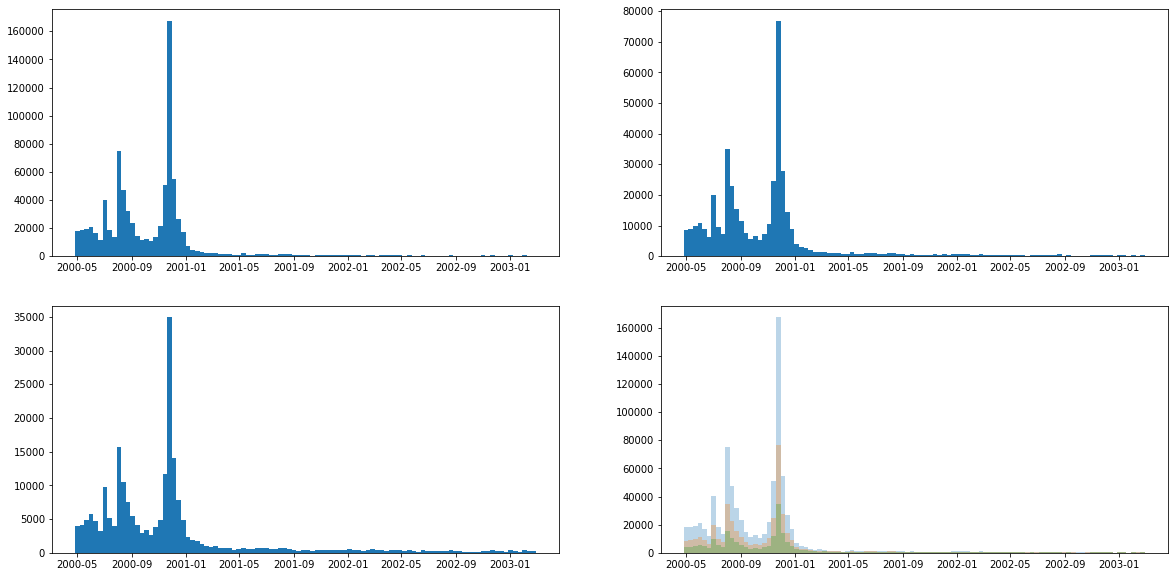

In [15]:
bins = 100

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
hist_nondrop, _, _ = axes[0, 0].hist(data['Date'], bins=bins)

hist_dropfirst, _, _ = axes[0, 1].hist(data_first['Date'], bins=bins)

hist_dropkeep, _, _ = axes[1, 0].hist(data_nonkeep['Date'], bins=bins)

axes[1, 1].hist(data['Date'], bins, alpha = 0.3, label='nondrop')
axes[1, 1].hist(data_first['Date'], bins, alpha = 0.3, label='drop_fist')
axes[1, 1].hist(data_nonkeep['Date'], bins, alpha = 0.3, label='drop_nonkeep')
plt.show()

중복 시간 정보를 삭제할 경우, 최대 160000까지 가던 높이가 35000정도 까지 줄었지만  
전체적인 데이터의 분포는 유지한 것을 볼 수 있다.

그리고 위의 그림처럼 거의 대부분의 데이터가 앞의 1년정도에 몰려있는 것을 확인 할 수 있다.  
이 부분을 그래프로 나타내어 보자.

In [16]:
x = np.linspace(data['Time'].min(), data['Time'].max(), 100)
f = lambda t: str(dt.datetime.utcfromtimestamp(t))
vfunc  = np.vectorize(f)
x = vfunc (x)

In [17]:
data = data.sort_values(by=['Time'])
data

,SessionId,ItemId,Rating,Time,Date
1000138,6040,858,4,956703932,2000-04-25 23:05:32
1000153,6040,2384,4,956703954,2000-04-25 23:05:54
999873,6040,593,5,956703954,2000-04-25 23:05:54
1000192,6040,2019,5,956703977,2000-04-25 23:06:17
1000007,6040,1961,4,956703977,2000-04-25 23:06:17
...,...,...,...,...,...
825526,4958,3489,4,1046454320,2003-02-28 17:45:20
825438,4958,1407,5,1046454443,2003-02-28 17:47:23
825731,4958,2634,3,1046454548,2003-02-28 17:49:08
825724,4958,3264,4,1046454548,2003-02-28 17:49:08


다음은 100개의 단위로 나눈 데이터의 포함율이다.

In [18]:
time_percent_cumsum = hist_nondrop.cumsum() / hist_nondrop.sum()
time_percent_cumsum

array([0.02171844, 0.0436712 , 0.06671186, 0.09202872, 0.11195871,
       0.12608461, 0.17430703, 0.19637576, 0.21269776, 0.30247657,
       0.35919534, 0.39750717, 0.42568005, 0.44294411, 0.45654757,
       0.47162029, 0.48421716, 0.50032637, 0.52614414, 0.58681998,
       0.78684676, 0.85225672, 0.88428865, 0.90481399, 0.91314894,
       0.91886577, 0.92376847, 0.927337  , 0.92984633, 0.93273822,
       0.93538384, 0.93715675, 0.93888423, 0.94080418, 0.9418849 ,
       0.94339241, 0.94590414, 0.94714386, 0.94853899, 0.95039917,
       0.95224979, 0.95392228, 0.95525644, 0.95660376, 0.95820093,
       0.95981365, 0.96143712, 0.96261229, 0.9632973 , 0.96460875,
       0.96543842, 0.96604812, 0.96683834, 0.96765964, 0.96868537,
       0.9697649 , 0.97083844, 0.97168246, 0.97279307, 0.97412723,
       0.97523545, 0.97647517, 0.97697728, 0.9778189 , 0.97913633,
       0.97979744, 0.98077296, 0.98151774, 0.98236176, 0.98332174,
       0.98411554, 0.98464395, 0.98544493, 0.98597333, 0.98635

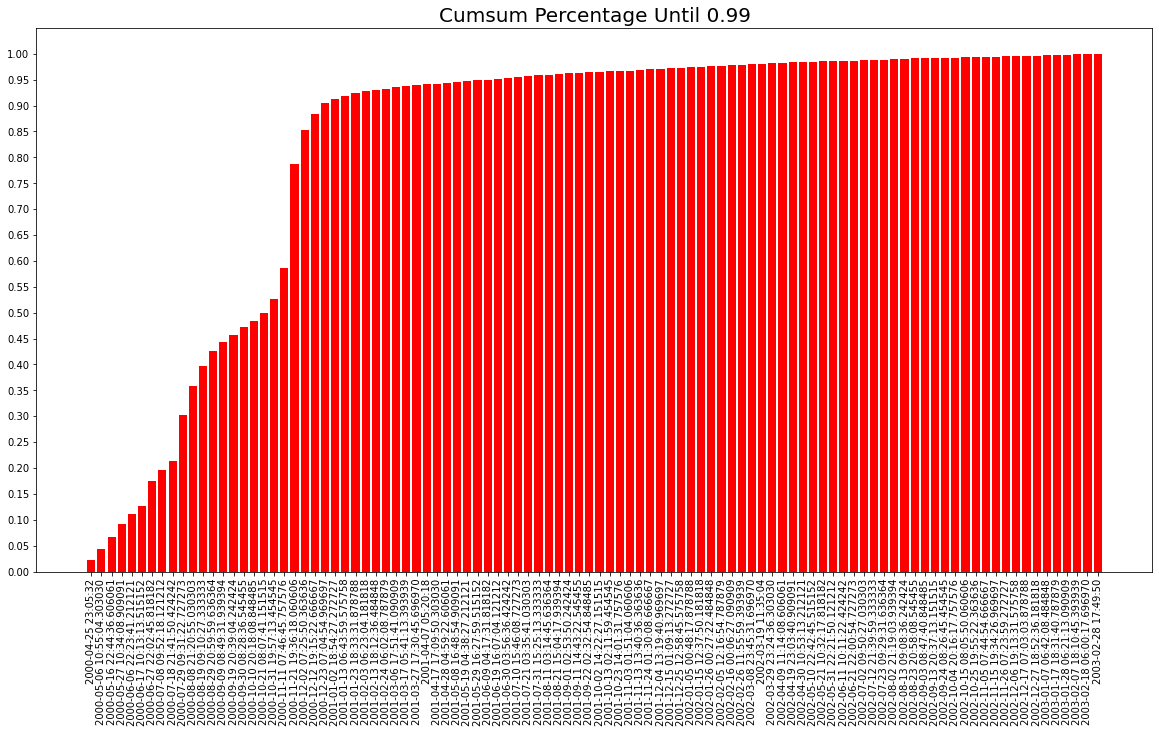

In [19]:
plt.figure(figsize=(20, 10))
plt.bar(x=x, height=time_percent_cumsum, color='red')
plt.yticks(np.arange(0, 1.01, 0.05))
plt.xticks(rotation=90)
plt.title('Cumsum Percentage Until 0.99', size=20)
plt.show()

역시 2001년 초까지의 데이터가 전체 데이터의 95퍼 정도를 차지한 것을 확인할 수 있다.  
많은 데이터가 몰려있는 2001년 1월까지의 데이터만 이용하여 학습을 시켜보자.

In [20]:
date_string = '2001-02-01 00:00:00'
last_date = dt.datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')
data = data[data['Date'] < last_date]
data

,SessionId,ItemId,Rating,Time,Date
1000138,6040,858,4,956703932,2000-04-25 23:05:32
1000153,6040,2384,4,956703954,2000-04-25 23:05:54
999873,6040,593,5,956703954,2000-04-25 23:05:54
1000192,6040,2019,5,956703977,2000-04-25 23:06:17
1000007,6040,1961,4,956703977,2000-04-25 23:06:17
...,...,...,...,...,...
490628,3018,3421,4,980978902,2001-01-31 22:08:22
490630,3018,3284,4,980978902,2001-01-31 22:08:22
491053,3018,1080,4,980978928,2001-01-31 22:08:48
490538,3018,1294,4,980978928,2001-01-31 22:08:48


최종적으로 사용할 시간의 범위이다.

In [21]:
oldest, latest = data['Date'].min(), data['Date'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2001-01-31 22:11:05


## Session Length

In [22]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1        53
2       116
3        46
4        19
5       143
       ... 
6036    708
6037    189
6038     18
6039    119
6040    253
Length: 6033, dtype: int64

In [23]:
print(f'중앙값 : {session_length.median()}, \t 평균값 : {session_length.mean()}')
print(f'최소값 : {session_length.min()}, \t 최대값 : {session_length.max()}')

중앙값 : 76.0, 	 평균값 : 128.09597215315765
최소값 : 1, 	 최대값 : 1856


각 세션에 대한 분포를 히스토그램으로 나타내 보면 다음과 같이 나온다.  
평균은 128이지만, 최대 1856의 길이를 가지는 분포를 보여준다.

하지만 현재 사용하는 세션데이터가 사실 userid에 대한 정보이므로,  
개인적인 차이와 큰 값을 가지는 것이 이상한 것은 아니다.  
다만 이것이 학습에 영향을 줄지는 좀 더 고민을 해봐야 할 것 같다.

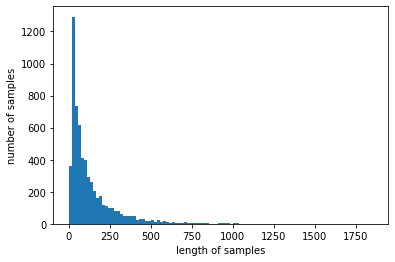

In [24]:
plt.hist(session_length.values, bins = 100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

시간과 마찬가지로 포함율 그래프를 그려보자.

In [25]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_99 = length_percent_cumsum[length_percent_cumsum < 0.99][100:600:10]

length_percent_cumsum_99

101    0.598210
111    0.628875
121    0.657882
131    0.681585
141    0.703133
151    0.726338
161    0.747389
171    0.763799
181    0.777557
191    0.791646
201    0.807393
211    0.820653
221    0.830433
231    0.839052
241    0.849660
251    0.858611
261    0.868059
271    0.876347
281    0.884137
291    0.891928
301    0.898558
311    0.905520
321    0.912481
332    0.917122
342    0.921266
352    0.926405
363    0.931212
374    0.935024
384    0.940162
394    0.943643
405    0.948450
415    0.952428
431    0.955743
445    0.959390
459    0.963037
472    0.965854
489    0.968341
505    0.971490
526    0.973976
545    0.976794
560    0.979281
584    0.981435
604    0.983756
631    0.985579
658    0.988231
dtype: float64

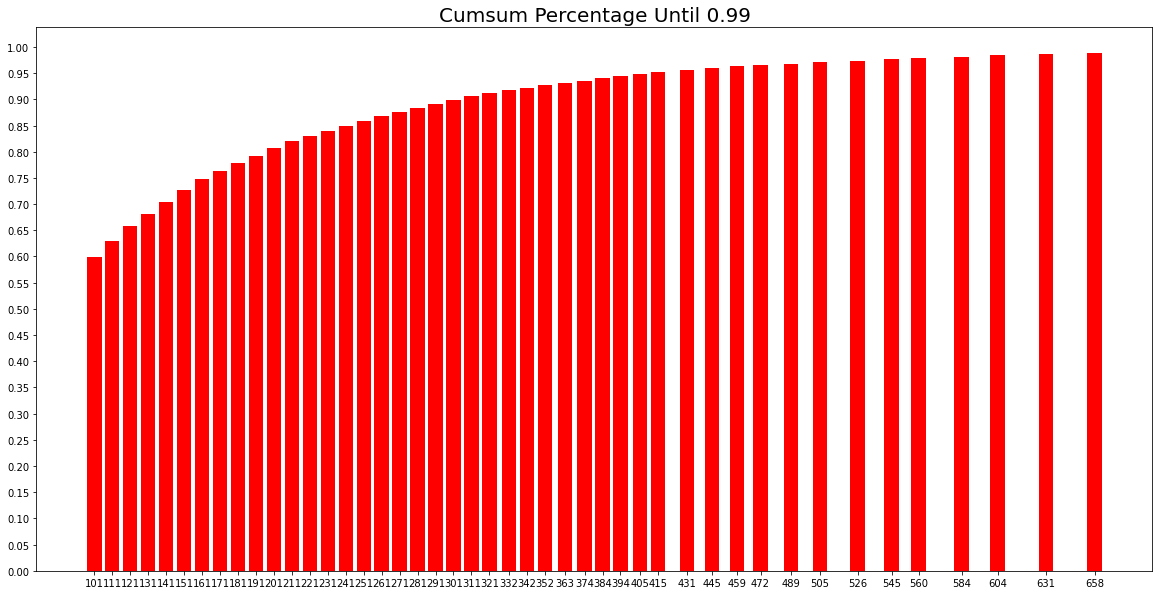

In [26]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_99.index, width=8,
        height=length_percent_cumsum_99, color='red')
plt.xticks(length_percent_cumsum_99.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.99', size=20)
plt.show()

길이 600정도 까지만 포함하여도 98퍼의 데이터를 포함한 데이터가된다.  
이 과정을 처리는 좀 더 고민해보자.

### Data Cleansing

명확한 1회 세션을 가지지 않는 데이터 셋이지만, 위의 처리과정에서  
세션의 길이가 1인 세션등이 발생 했을 수도 있으므로 다음 과정들을 처리해 주자.

In [27]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [28]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,SessionId,ItemId,Rating,Time,Date
1000138,6040,858,4,956703932,2000-04-25 23:05:32
1000153,6040,2384,4,956703954,2000-04-25 23:05:54
999873,6040,593,5,956703954,2000-04-25 23:05:54
1000192,6040,2019,5,956703977,2000-04-25 23:06:17
1000007,6040,1961,4,956703977,2000-04-25 23:06:17
...,...,...,...,...,...
490628,3018,3421,4,980978902,2001-01-31 22:08:22
490630,3018,3284,4,980978902,2001-01-31 22:08:22
491053,3018,1080,4,980978928,2001-01-31 22:08:48
490538,3018,1294,4,980978928,2001-01-31 22:08:48


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 772138 entries, 1000138 to 490521
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   SessionId  772138 non-null  int32         
 1   ItemId     772138 non-null  int32         
 2   Rating     772138 non-null  int32         
 3   Time       772138 non-null  int64         
 4   Date       772138 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(3), int64(1)
memory usage: 26.5 MB


대략 700개 정도의 데이터가 제거 되었다.

## 3. 미니 배치의 구성

### Train/ Valid/ Test split

현재 총 데이터 개수는 770000개 정도이다.  

영화의 추천은 물품의 추천보다 좀 더 넓은 범위의 트랜드 범위를 가질 것으로 예상된다.  
현재 데이터의 길이가 8개월 정도의 데이터 이므로 끝 부분의 영화를 추천하는데  
크게 문제가 되지 않을 것이라고 판단하고 단순하게 현재 데이터를  나누어보자.

In [30]:
tr = data[:600000]
val = data[600000:700000]
test = data[700000:]

In [31]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Date"].min()}\n'
          f'\t Last Time : {data["Date"].max()}\n')

나눈 데이터 셋의 정보들을 확인해보자.

In [32]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 600000
	 Sessions: 4937
	 Items: 3271
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2000-11-22 22:04:47

* valid Set Stats Info
	 Events: 100000
	 Sessions: 1133
	 Items: 3149
	 First Time : 2000-11-22 22:04:51
	 Last Time : 2000-12-08 14:26:34

* test Set Stats Info
	 Events: 72138
	 Sessions: 1141
	 Items: 3088
	 First Time : 2000-12-08 14:26:34
	 Last Time : 2001-01-31 22:11:05



In [33]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [34]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### SessionDataset

GRU4REC 논문에서 사용된 Session-Parallel Mini-Batches를 사용해보자.

In [35]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [36]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,ItemId,Rating,Time,Date,item_idx
1000138,6040,858,4,956703932,2000-04-25 23:05:32,0
1000153,6040,2384,4,956703954,2000-04-25 23:05:54,1
999873,6040,593,5,956703954,2000-04-25 23:05:54,2
1000192,6040,2019,5,956703977,2000-04-25 23:06:17,3
1000007,6040,1961,4,956703977,2000-04-25 23:06:17,4
999877,6040,1419,3,956704056,2000-04-25 23:07:36,5
999920,6040,213,5,956704056,2000-04-25 23:07:36,6
999967,6040,3111,5,956704056,2000-04-25 23:07:36,7
999980,6040,3505,4,956704056,2000-04-25 23:07:36,8
999868,6040,573,4,956704056,2000-04-25 23:07:36,9


In [37]:
tr_dataset.click_offsets

array([     0,      9,     31, ..., 599628, 599747, 600000], dtype=int32)

In [38]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 4934, 4935, 4936])

###  SessionDataLoader

In [39]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [40]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,ItemId,Rating,Time,Date,item_idx
1000138,6040,858,4,956703932,2000-04-25 23:05:32,0
1000153,6040,2384,4,956703954,2000-04-25 23:05:54,1
999873,6040,593,5,956703954,2000-04-25 23:05:54,2
1000192,6040,2019,5,956703977,2000-04-25 23:06:17,3
1000007,6040,1961,4,956703977,2000-04-25 23:06:17,4
999877,6040,1419,3,956704056,2000-04-25 23:07:36,5
999920,6040,213,5,956704056,2000-04-25 23:07:36,6
999967,6040,3111,5,956704056,2000-04-25 23:07:36,7
999980,6040,3505,4,956704056,2000-04-25 23:07:36,8
999868,6040,573,4,956704056,2000-04-25 23:07:36,9


In [41]:
iter_ex = iter(tr_data_loader)

In [42]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0  9 31 35]
Label Item Idx are :       [ 1 10 32 36]
Previous Masked Input Idx are []


## 4. 모델 구성

### Evaluation Metric

In [43]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [44]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [45]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=1024, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [46]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1024, 1, 3271)]         0         
_________________________________________________________________
GRU (GRU)                    [(1024, 50), (1024, 50)]  498450    
_________________________________________________________________
dropout (Dropout)            (1024, 50)                0         
_________________________________________________________________
dense (Dense)                (1024, 3271)              166821    
Total params: 665,271
Trainable params: 665,271
Non-trainable params: 0
_________________________________________________________________


## 5. 모델 학습

In [47]:

# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [48]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/581 [00:00<?, ?it/s, accuracy=0.00684, train_loss=7.3] 

	 - Recall@20 epoch 1: 0.066895
	 - MRR@20    epoch 1: 0.013892



Train:   0%|          | 0/581 [00:00<?, ?it/s, accuracy=0.00977, train_loss=7.2] 

	 - Recall@20 epoch 2: 0.072754
	 - MRR@20    epoch 2: 0.015847



Evaluation:   2%|▏         | 2/96 [00:12<09:27,  6.03s/it]

	 - Recall@20 epoch 3: 0.080078
	 - MRR@20    epoch 3: 0.021183



학습과정에서 Recall 과 MRR이 개선되는 것을 확인할 수 있다.

다만 데이터셋을 잘 만들지 못했는지 성능이 좋지 않다.

### 6. 모델 테스트

In [49]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   1%|▏         | 1/69 [00:06<06:51,  6.05s/it]

	 - Recall@20: 0.073242
	 - MRR@20: 0.018513



## 7. 회고

저번에 이어서 두번째로 추천시스템을 만들어 보았다.

이번 프로젝트는 MF모델을 이용한 저번과는 다르게 세션기반의 추천시스템이었다.  
단순하게 어떻게 하는 방식인지는 이해가 가지만 실제 코드를 구현하면서 저번과 다르게  
헷갈리는 부분도 많고 이해가지는 않는 코드도 많았다.

거기에 데이터 셋 자체가 세션으로 주어진게 아닌 유저로 식별된걸 세션으로 바꾸면서  
그 부분에서 많은 문제가 생긴게 아닐까 예상해 본다.

그래도 새로운 추천 시스템의 한 부분에 대한 공부는 된것 같아 다행이다.